In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train\AKIEC 964
data/train\BCC 1537
data/train\BKL 3275
data/train\DF 346
data/train\MEL 3308
data/train\NV 20050
data/train\VASC 436


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation\AKIEC 344
data/validation\BCC 519
data/validation\BKL 1121
data/validation\DF 114
data/validation\MEL 1144
data/validation\NV 6770
data/validation\VASC 132


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = True)

Found 29916 images belonging to 7 classes.
Found 10144 images belonging to 7 classes.


In [7]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5


adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))
model.add(Dropout(rate=droput_rate))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2000,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1000)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2000/2000 [==============================] - 1236s 618ms/step - loss: 0.7346 - acc: 0.7465 - val_loss: 0.4350 - val_acc: 0.8432
Epoch 2/50
2000/2000 [==============================] - 1214s 607ms/step - loss: 0.2845 - acc: 0.9039 - val_loss: 0.2307 - val_acc: 0.9233
Epoch 3/50
2000/2000 [==============================] - 1216s 608ms/step - loss: 0.1025 - acc: 0.9710 - val_loss: 0.1668 - val_acc: 0.9462
Epoch 4/50
2000/2000 [==============================] - 1216s 608ms/step - loss: 0.0370 - acc: 0.9918 - val_loss: 0.1523 - val_acc: 0.9549
Epoch 5/50
2000/2000 [==============================] - 1216s 608ms/step - loss: 0.0187 - acc: 0.9961 - val_loss: 0.1553 - val_acc: 0.9559
Epoch 6/50
2000/2000 [==============================] - 1214s 607ms/step - loss: 0.0100 - acc: 0.9982 - val_loss: 0.1570 - val_acc: 0.9558
Epoch 7/50
2000/2000 [==============================] - 1214s 607ms/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.1577 - val_acc: 0.9579
Epoch 8/50
2000/2000 [================

In [11]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.22207001045278957
Test Accuracy:  0.960625


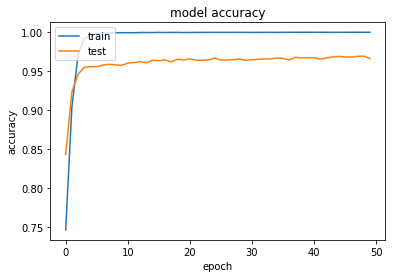

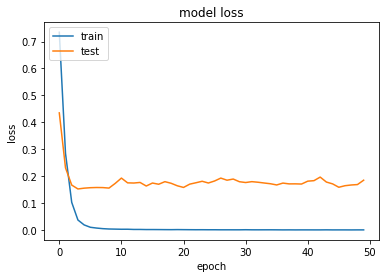

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [14]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

317/317 [==============================] - 38s 119ms/step
No of errors = 5278/10144


Confusion matrix
[[   9   26   42    1   33  230    3]
 [  19   33   51    5   46  358    7]
 [  37   68  109    8  113  778    8]
 [   6    7   15    1   12   72    1]
 [  35   55  107   12  127  788   20]
 [ 211  338  730   75  735 4583   98]
 [   7    7   12    2   15   85    4]]


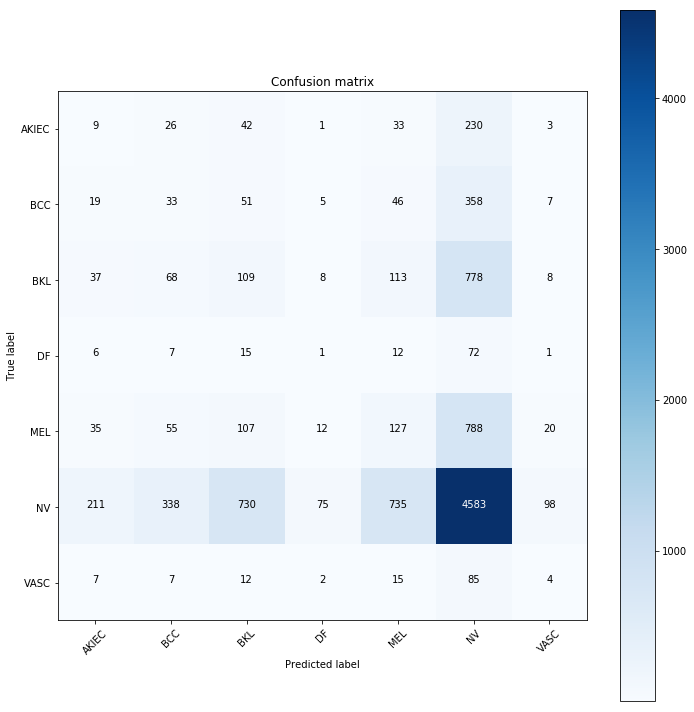

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [17]:
predict_and_report(train_generator, model)

c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Accuracy: 0.08360074876320364
Area Under the Receiver Operating Characteristic Curve: 0.033968779731491594
              precision    recall  f1-score   support

           0       1.00      0.03      0.07     28379
           1       1.00      1.00      1.00      1537
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

   micro avg       0.08      0.08      0.08     29916
   macro avg       0.29      0.15      0.15     29916
weighted avg       1.00      0.08      0.11     29916



c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
predict_and_report(validation_generator, model)

Accuracy: 0.07916009463722397
Area Under the Receiver Operating Characteristic Curve: 0.05809503791006683
              precision    recall  f1-score   support

           0       0.99      0.03      0.06      9625
           1       0.95      0.93      0.94       519
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

   micro avg       0.08      0.08      0.08     10144
   macro avg       0.28      0.14      0.14     10144
weighted avg       0.99      0.08      0.11     10144



In [19]:
model.save('models/2.Xception-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception-Adam-without-Dropout-Weights.h5')